# Keldy: Playground

## Imports & Setup Properties

In [1]:
import os
import sys
import glob
import copy
import itertools

import h5py

import math
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import scipy.integrate


In [2]:
import mpi4py
import mpi4py.MPI

### Plotting

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

In [4]:
#Plotting Options
markslist='o^v<>dhps*HD'
cmap = plt.get_cmap('plasma')
color_list_limit = 2

def f_colorlist(i, offset = 0, cycle = color_list_limit):
    return cmap(float((i+offset)%cycle) / cycle)

def f_markslist(i, offset = 0, cycle = color_list_limit):
    return markslist[((i+offset)%cycle)]

### Keldy Import

In [5]:
from pytriqs.gf import *
from pytriqs.plot.mpl_interface import oplot,plt

import keldy.impurity_oneband_module as k_imp

## Model g0

In [6]:
anderson_param = {
    "beta": 10000.0, 
    "bias_V" : 0.0,
    "eps_d": -0.0,
    "Gamma": 0.25,
    "time_max": +500.0,
    "nr_time_points_gf": 100000,
    "bath_type": "semicircle"
}

In [7]:
g0 = k_imp.G0Model(**anderson_param)

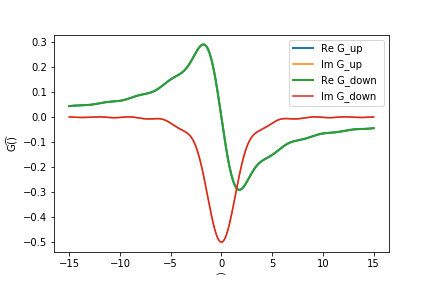

In [8]:
oplot(g0.g0_greater, '-', linewidth=2, x_window=(-15,15)) 

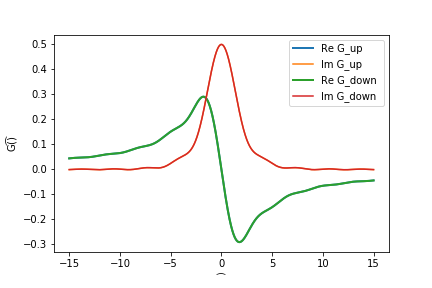

In [9]:
oplot(g0.g0_lesser, '-', linewidth=2, x_window=(-15,15)) 

### Keldysh Adaptor

In [10]:
g0K = k_imp.G0KeldyshContourT(g0)

In [11]:
# g0K(k_imp.GfIndexT(t[i], 0, 0), k_imp.GfIndexT(0, 0, 0))

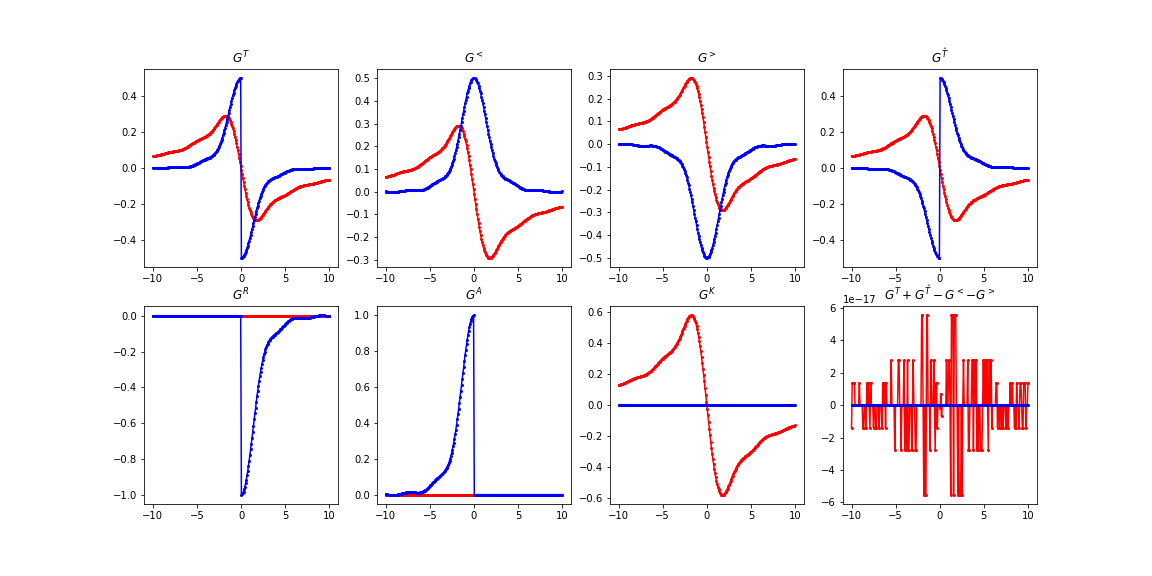

In [12]:
fig = plt.figure(figsize=(16,8))

t = np.linspace(-10,10,250)

g_ff = np.zeros(len(t), dtype='c16')
g_fb = np.zeros(len(t), dtype='c16')
g_bf = np.zeros(len(t), dtype='c16')
g_bb = np.zeros(len(t), dtype='c16')
gR = np.zeros(len(t), dtype='c16')
gA = np.zeros(len(t), dtype='c16')
gK = np.zeros(len(t), dtype='c16')
g_cancel = np.zeros(len(t), dtype='c16')

for i in range(len(t)):
    g_ff[i]  = g0K(k_imp.GfIndexT(t[i], 0, 0), k_imp.GfIndexT(0, 0, 0), True) 
    g_fb[i]  = g0K(k_imp.GfIndexT(t[i], 0, 0), k_imp.GfIndexT(0, 0, 1), True) 
    g_bf[i]  = g0K(k_imp.GfIndexT(t[i], 0, 1), k_imp.GfIndexT(0, 0, 0), True) 
    g_bb[i]  = g0K(k_imp.GfIndexT(t[i], 0, 1), k_imp.GfIndexT(0, 0, 1), True) 

    gR[i]  = g_ff[i] - g_fb[i]
    gA[i]  = g_ff[i] - g_bf[i]
    gK[i]  = g_ff[i] + g_bb[i]
    
    g_cancel[i] = g_ff[i] + g_bb[i] - g_bf[i] - g_fb[i]

plt_list = [(g_ff, "$G^T$"), (g_fb, "$G^<$"), (g_bf, "$G^>$"), (g_bb, r"$G^{\hat{T}}$"), (gR, "$G^R$"), (gA, "$G^A$"), (gK, "$G^K$"), (g_cancel, "$G^T + G^{\hat{T}} - G^< - G^>$")]
for (i_p, (fun, label)) in enumerate(plt_list):
    ax0 = plt.subplot(2,4,i_p + 1)
    ax0.plot(t, fun.real, marker='o', markersize=2, color='red')
    ax0.plot(t, fun.imag, marker='o', markersize=2, color='blue')
    ax0.set_title(label)
#     ax0.set_scale.

plt.show()

In [13]:
# fig = plt.figure(figsize=(16,8))

# plt_list = [(g_ff, "$G^T$"), (g_fb, "$G^<$"), (g_bf, "$G^>$"), (g_bb, r"$G^{\hat{T}}$"), (gR, "$G^R$"), (gA, "$G^A$"), (gK, "$G^K$"), (g_cancel, "$G^T + G^{\hat{T}} - G^< - G^>$")]
# for (i_p, (fun, label)) in enumerate(plt_list):
#     ax0 = plt.subplot(2,4,i_p + 1)
#     ax0.plot(t, np.abs(fun) / np.abs(g_fb + g_bf), marker='o', markersize=2, color='red')
# #     ax0.plot(t, fun.imag, marker='o', markersize=2, color='blue')
#     ax0.set_title(label)
# #     ax0.set_scale.

# plt.show()

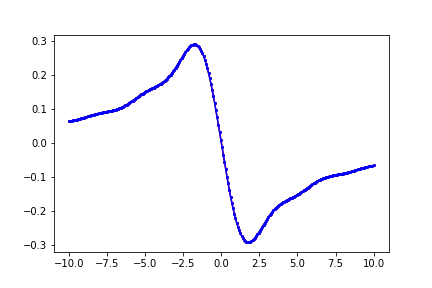

In [14]:
fig = plt.figure()
ax0 = plt.subplot(1,1,1)
ax0.plot(t, g_fb.real, marker='o', markersize=2, color='red')
ax0.plot(t, g_bf.real, marker='o', markersize=2, color='blue')




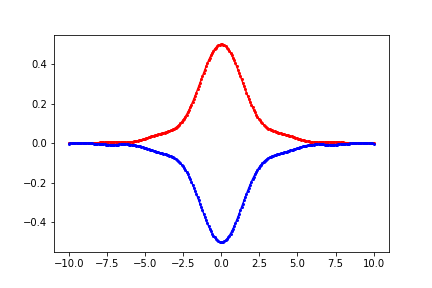

In [15]:
fig = plt.figure()
ax0 = plt.subplot(1,1,1)
ax0.plot( t, g_fb.imag, marker='o', markersize=2, color='red')
ax0.plot(t, g_bf.imag, marker='o', markersize=2, color='blue')





## Wick

In [16]:
kp_ext_1 =  k_imp.GfIndexT(10.0, 0, 0)
kp_ext_2 =  k_imp.GfIndexT(10.0, 0, 1)

my_integrand =  k_imp.IntegrandGT1t2Direct(g0K, kp_ext_1, kp_ext_2)

### Order 0 Calculation

In [17]:
# Numerics
t = np.linspace(0.0,10.0,100)
t_list = [list([]) for t0 in t]
g_order0 = np.array(map(my_integrand, t_list))

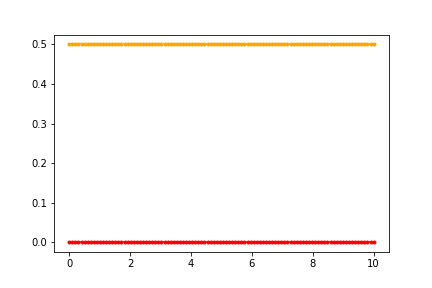

In [18]:
plt.plot(t, g_order0.real, marker='o', markersize=3, color='red')
plt.plot(t, g_order0.imag, marker='o', markersize=3, color='orange')
plt.show()

### Order 1 Calculation

In [19]:
my_integrand([0.00])

(-0.00014709121004657165+1.2628786905111156e-14j)

In [20]:
t = np.linspace(0.0,10.0,500)
t_list = [list([t0]) for t0 in t]
g_order1 = np.array(map(my_integrand, t_list))

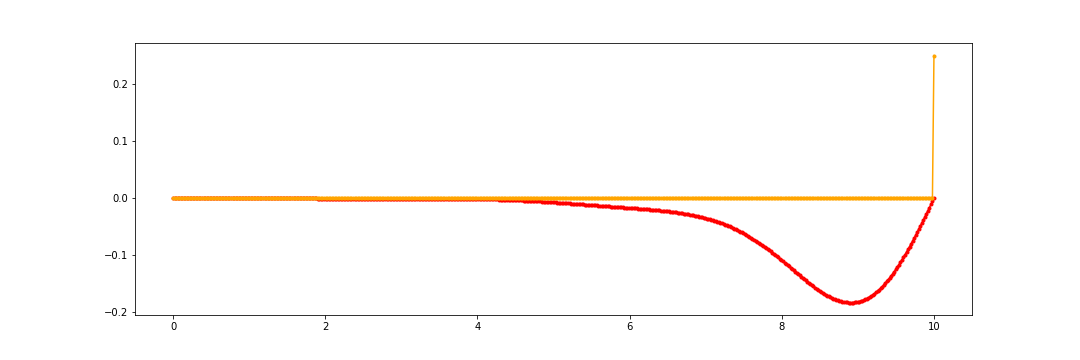

In [21]:
fig = plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,1,1)
ax0.plot(t, g_order1.real, marker='o', markersize=3, color='red')
ax0.plot(t, g_order1.imag, marker='o', markersize=3, color='orange')
# ax0.plot(t, np.abs(g_order1), marker='o', markersize=3, color='blue')


# ax1.set_yscale('log')
plt.show()

In [22]:
t_max = 10.0

def f1_w(t):
    return 1e-6 + np.abs(my_integrand([t_max -1e-12- t])) + 80

my_w = k_imp.WarperPlasmaSimpleT(f1_w, t_max, 1000)

In [23]:
t = np.linspace(0.0,10.0,500)
t_list = [list([t0]) for t0 in t]
g_order1_w = np.array(map(my_w.evaluate_warping_function, t_list))

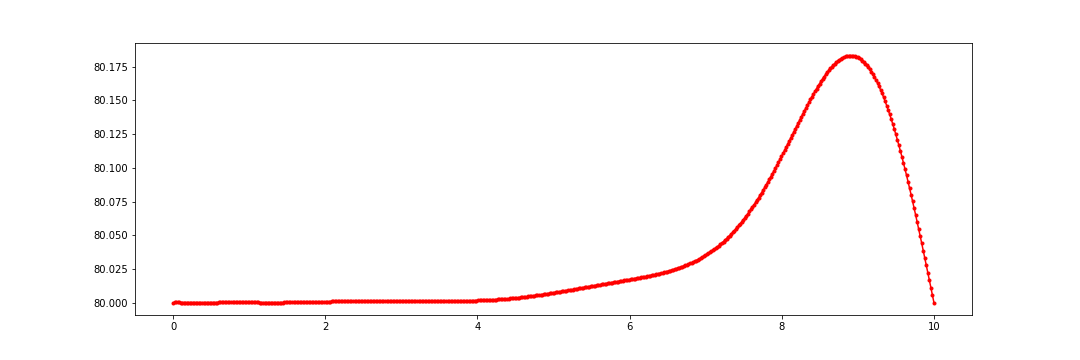

In [24]:
fig = plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,1,1)
ax0.plot(t, g_order1_w, marker='o', markersize=3, color='red')
# ax1.set_yscale('log')
plt.show()

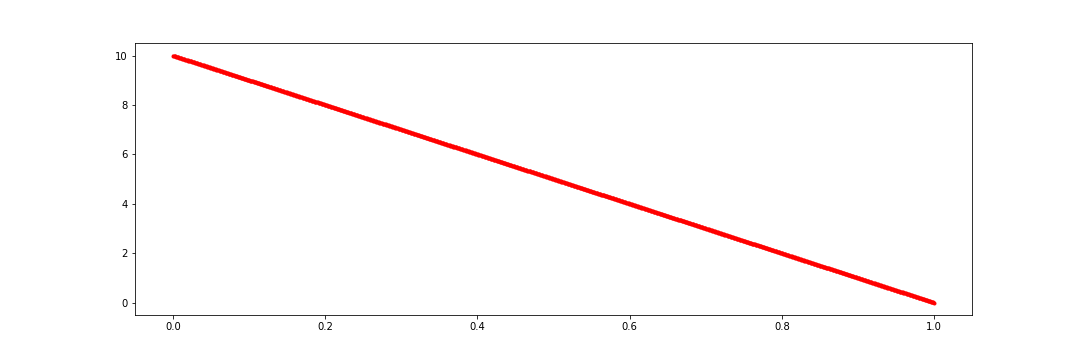

In [25]:
fig = plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,1,1)


l = np.linspace(0.0,1.0,1000)
l_list = [list([l0]) for l0 in l]

ax0.plot(l, np.array(map(my_w.ui_from_li, l_list)), marker='o', markersize=3, color='red')
# ax1.set_yscale('log')
plt.show()



### Order 2 Calculation

In [26]:
# fig = plt.figure(figsize=(15,5))
# ax0 = plt.subplot(1,1,1)
# ax0.plot(t, g_order2.real, marker='o', markersize=3, color='red')
# ax0.plot(t, g_order2.imag, marker='o', markersize=3, color='orange')

# # ax1.set_yscale('log')
# plt.show()

In [27]:
u_list_p = []
u_list = []
v_list = []

nr_sample_edge = 250
delta_t = t_max / nr_sample_edge

for i_t1 in range(nr_sample_edge):
    for i_t2 in range(nr_sample_edge):
        times = np.array([delta_t * i_t1, delta_t * i_t2])
        times = np.sort(times)[::-1]
        u_list_p.append(k_imp.ui_from_vi(t_max, k_imp.vi_from_ui(t_max, times)))
        v_list.append(k_imp.vi_from_ui(t_max, times))
        u_list.append(times)

g_order2   = np.array(map(my_integrand, u_list))
g_order2_w = np.array(map(my_w.evaluate_warping_function, u_list))

(62500, 62500, 62500)


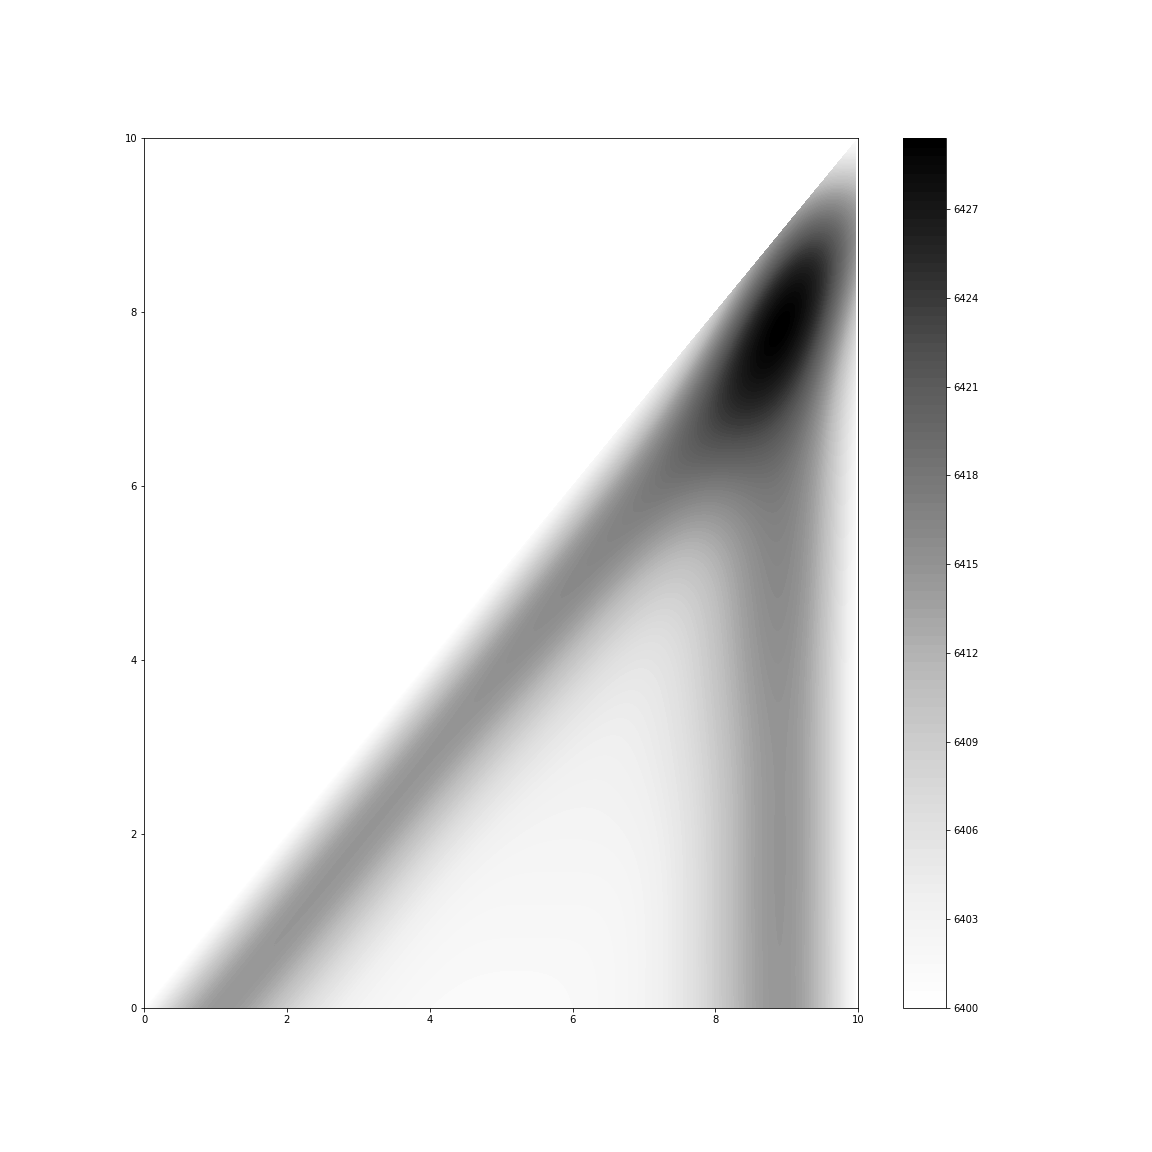

In [28]:
y = np.array(u_list)[:,1]
x = np.array(u_list)[:,0]
z = g_order2_w
print(len(x), len(y), len(z))
from scipy.interpolate import griddata

xi = np.linspace(0.0,10.0,500)
yi = np.linspace(0.0,10.0,500)

zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

fig = plt.figure(figsize=(16,16))
plt.contourf(xi,yi,zi, 100,cmap=plt.cm.Greys, vmin=z.min(), vmax=z.max())
plt.colorbar() # draw colorbar
# plt.scatter(x,y,marker='o',c='y', s=0.1)


plt.show()

[12800.00032    12801.79152699 12803.55193933 ... 12805.30482885
 12803.54135665 12801.77071589]
(62500, 62500, 62500)


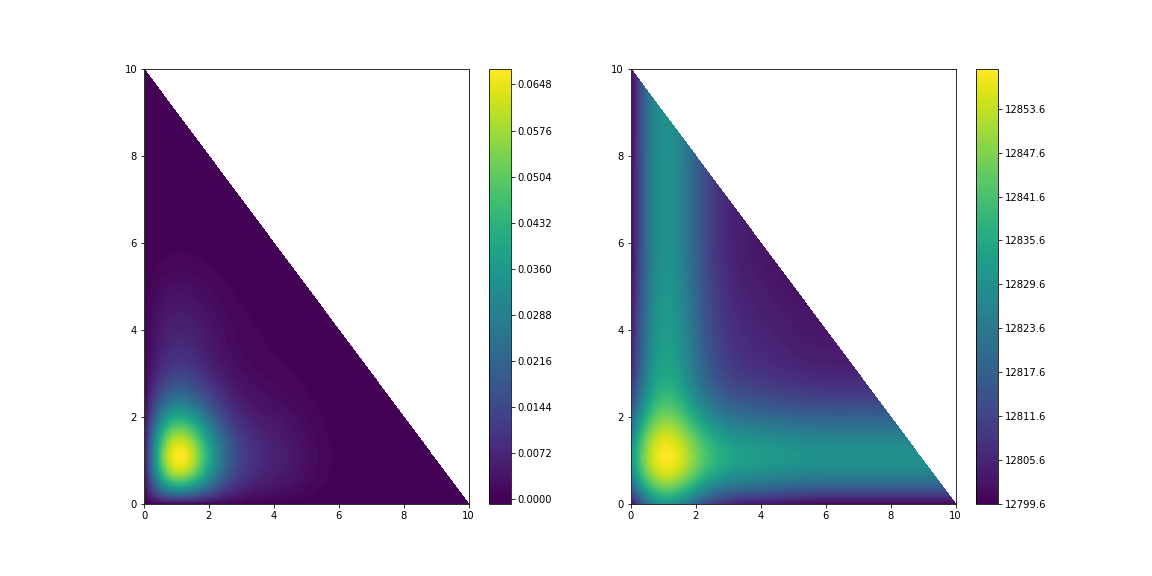

In [29]:
# # plt.plot(t_list, g_order2.real, marker='o', markersize=3)

# X, Y = np.meshgrid(, np.array(t_list)[:,1])

# plt.contour(X, Y, g_order2.real)#, marker='o', markersize=3)

y = np.array(v_list)[:,1]
x = np.array(v_list)[:,0]
z = np.abs(g_order2)

from scipy.interpolate import griddata


xi = np.linspace(0.0,10.0,500)
yi = np.linspace(0.0,10.0,500)

zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')


fig = plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
# plt.contour(xi,yi,zi,linewidths=0.5,colors='k', vmin=z.min(), vmax=z.max())
plt.contourf(xi,yi,zi, 100,vmin=z.min(), vmax=z.max())
plt.colorbar() # draw colorbar
# plot data points.
# plt.scatter(x,y,marker='o',c='y', s=0.1)
# plt.xlim(-2,2)
# plt.ylim(-2,2)
# plt.title('griddata test (%d points)' % npts)

plt.subplot(1,2,2)

y = np.array(v_list)[:,1]
x = np.array(v_list)[:,0]
z = 2 *  g_order2_w #/ np.abs(g_order2)
print(z)
print(len(x), len(y), len(z))
from scipy.interpolate import griddata

xi = np.linspace(0.0,10.0,500)
yi = np.linspace(0.0,10.0,500)

zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

plt.contourf(xi,yi,zi, 100, )
plt.colorbar() # draw colorbar
# plt.scatter(x,y,marker='o',c='y', s=0.1)



plt.show()

## Run a Measurement

In [30]:
# import os
# os.environ['OMP_NUM_THREADS'] = "8"


In [51]:
order = 3
computer = k_imp.ComputeChargeQ(order, 10.0, g0.param_, int(1e6))
N_tot = 0

In [52]:
result = []
N_vec = []

currN = 0

In [53]:
for i in range(1000):
    step = 10000
    computer.run(step)
    currN += step
    result.append((-1j)*(-1j)**order * computer.reduce_result() )
    N_vec.append(currN)



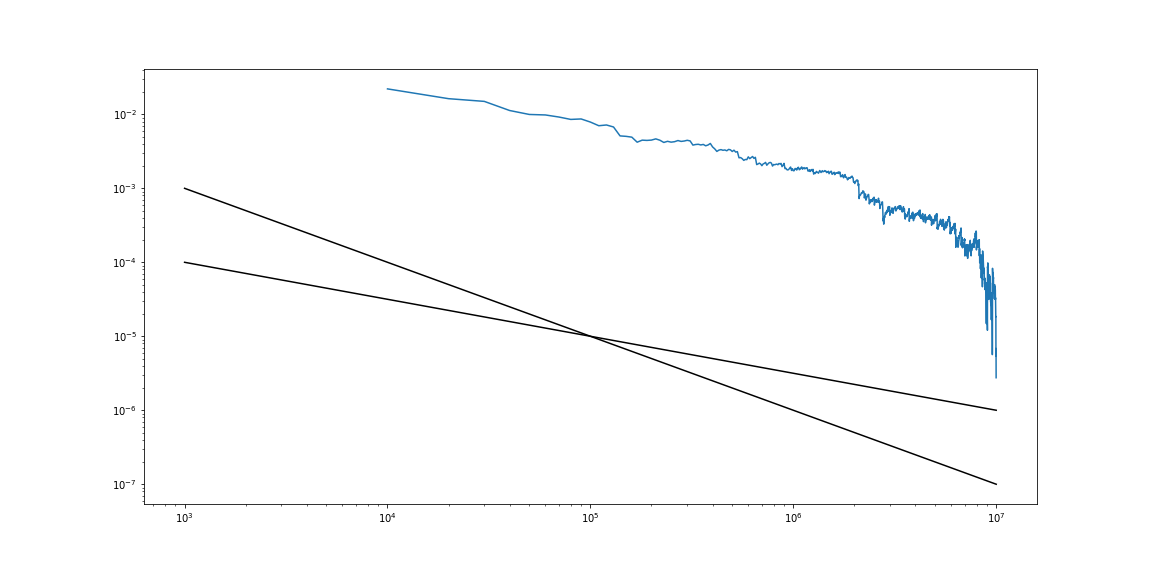

In [54]:
fig = plt.figure(figsize=(16,8))

plt.loglog(N_vec, np.abs(np.array(result).real - np.array(result).real[-1] ))

plt.loglog([10**3, 10**7], [10**-3, 10**-7], c='k')
plt.loglog([10**3, 10**7], [10**-4, 10**-6], c='k')



# plt.ylim(0, 1)

In [48]:
(-1j)*(-1j)**order * computer.reduce_result() 

(0.28524784457411856-5.2541342586517576e-11j)

In [40]:
computer.get_nr_points_run() 

10000000

In [49]:
result_1 = 0.37803744008391754
result_2 = 0.28524784457411856

## SciPy Integral

In [37]:
def lim0():
    return [0, 10.0]

def lim1(t1):
    return [0, t1]

def lim2(t1, t2):
    return [0, t2]

result_1_sp = sp.integrate.nquad(lambda x: my_integrand([x]).real, [lim0], opts={'limit': 50}, full_output=True)
result_2_sp = sp.integrate.nquad(lambda x, y: my_integrand([x, y]).imag, [lim1, lim0], opts={'limit': 50}, full_output=True)
# result_3_sp = sp.integrate.nquad(lambda x, y, z: my_integrand([x, y, z]).real, [lim2, lim1, lim0], opts={'limit': 50}, full_output=True)


In [38]:
print "Order 1:", result_1_sp
print "Order 2:", result_2_sp

Order 1: (-0.37803748568485845, 1.1897818807089765e-06, {'neval': 1071})
Order 2: (-0.2852466703379883, 2.6165824019658853e-06, {'neval': 424347})


In [50]:
print result_1 + result_1_sp[0]
print result_2 + result_2_sp[0]

-4.56009409122e-08
1.17423613027e-06


In [ ]:
## Cuba Evaluation

### Cubature Evaulation

In [41]:
from cubature import cubature# S.Johnson package # https://github.com/saullocastro/cubature

In [42]:
#Order 1

def order_1_vectorize(t):
    t_list = [list(t0) for t0 in t]
    out = np.transpose(np.array([map(my_integrand, t_list)]))
    return np.real(out[:,0])

xmin = [ 0.0]
xmax = [10.0 - 1e-10]
result_1_cub_val, result_1_cub_err = cubature(order_1_vectorize, 1, 1, xmin, xmax, vectorized=True, abserr=1e-10, relerr=1e-10, adaptive='p')
print result_1_cub_val[0], ",", result_1_cub_err[0]

-0.3780374601590787 , 1.0386247417670802e-11


In [43]:
print result_1 + result_1_cub_val[0]

-2.0075161144550435e-08


In [ ]:
def my_integrand_order2_scaled(t):
    return t[0] * my_integrand([t[0], t[0] * t[1]])


def order_2_scalar(t):
    t_list = [list(t0) for t0 in list(t)]
    out = np.imag(t[:, 0] * np.transpose(np.array([map(my_integrand_order2_scaled, t_list)])))
    return out[:,0]
#     return np.imag(t[0] * my_integrand([t[0], t[0] * t[1]]))

xmin = [0.0, 0.0]
xmax = [10.0, 1.0]
result_2_cub_val, result_2_cub_err = cubature(order_2_scalar, 2, 1, xmin, xmax, vectorized=True, abserr=1e-4, relerr=1e-4, adaptive='p')
print result_2_cub_val[0], ",", result_2_cub_err[0]

In [ ]:
print result_2 + result_2_cub_val[0]

In [39]:
def integrand_rectangle(x_array):
    return 1.

def integrand_rectangle_v(x_array):
    return np.ones_like(x_array[:, 0])

def integrand_circle(x_array):
    return x_array[0]

def integrand_circle_v(x_array):
    return x_array[:, 0]

def exact_rectangle(a, b):
    return a*b

def exact_circle(r):
    return math.pi*r**2

# rectangle
print('_________________')
print('')
print('Rectangle')
a, b = 3, 5
xmin = [0, 0]
xmax = [a, b]
val, err = cubature(integrand_rectangle, 2, 1, xmin, xmax)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_rectangle(a, b)))
# rectangle (vectorized)
print('_________________')
print('')
print('Rectangle (vectorized)')
a, b = 3, 5
xmin = [0, 0]
xmax = [a, b]
val, err = cubature(integrand_rectangle_v, 2, 1, xmin, xmax, vectorized=True)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_rectangle(a, b)))
# circle
print('_________________')
print('')
print('Circle')
r = 3.
xmin = [0, 0]
xmax = [r, 2*math.pi]
val, err = cubature(integrand_circle, 2, 1, xmin, xmax)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_circle(r)))
print('_________________')
# circle (vectorized)
print('_________________')
print('')
print('Circle (vectorized)')
r = 3.
xmin = [0, 0]
xmax = [r, 2*math.pi]
val, err = cubature(integrand_circle_v, 2, 1, xmin, xmax, vectorized=True)
print('Approximated: {0}'.format(val))
print('Exact: {0}'.format(exact_circle(r)))
print('_________________')


_________________

Rectangle
Approximated: [15.]
Exact: 15
_________________

Rectangle (vectorized)
Approximated: [15.]
Exact: 15
_________________

Circle
Approximated: [28.27433388]
Exact: 28.2743338823
_________________
_________________

Circle (vectorized)
Approximated: [28.27433388]
Exact: 28.2743338823
_________________


## Factorial vs Power Nr of Operations

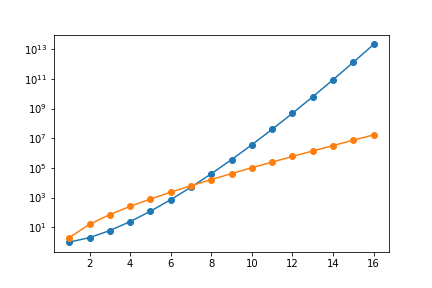

In [17]:
## Figure out exact FLOP scaling

x = np.linspace(1,16,16, dtype=int)
y_fac = map(np.math.factorial, x)#.linspace(1,10,10, dtype=int)
y_det = np.power(2, x) * np.square(x)

plt.plot(x, y_fac, marker='o')
plt.plot(x, y_det,  marker='o')
plt.yscale('log')

In [134]:
1+1

2